In [1]:
import pandas as pd
from ArimaFunctions import *

#### Preliminary analysis of data and stationarity / ACF / PCF plots for AS14.01

In [2]:
df = pd.read_csv('data/data_arima.csv')

            mood
time            
2014-02-17   NaN
2014-02-18   NaN
2014-02-19   NaN
2014-02-20   NaN
2014-02-21   NaN
...          ...
2014-05-01   8.0
2014-05-02   7.6
2014-05-03   8.0
2014-05-04   8.0
2014-05-05   NaN

[78 rows x 1 columns]


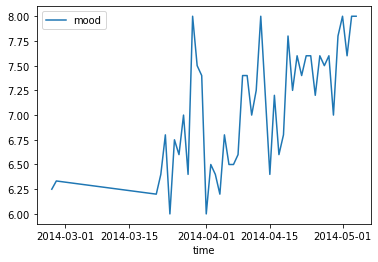

In [5]:
mood = getPersonMoodArimaSet(df, "AS14.01")
print(mood)
sns.lineplot(data=mood)

Stationarity check.

In [6]:
mood_dropna = mood.dropna() ## drop NaN's because adfuller cannot handle nans
result = adfuller(mood_dropna)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.5182590351214746
p-value: 0.007530360619884317
Critical Values:
	1%: -3.5812576580093696
	5%: -2.9267849124681518
	10%: -2.6015409829867675


This is unexpected to me, because it should be stationary when p value < 0.05 and critical values reasonably close to ADF statistic (according to https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7). 

The graph does not seem stationary to me (there is a clear upwards trend) but these values seem to indicate that the mood data is in fact stationary.

Analyse what happens if we cut off the missing days (there is a big gap) in the beginning and the 1 missing day at the end:

In [7]:
mood_cutoff = mood.iloc[32:-1] ## drop everything before streak
print(mood_cutoff)

            mood
time            
2014-03-21  6.20
2014-03-22  6.40
2014-03-23  6.80
2014-03-24  6.00
2014-03-25  6.75
2014-03-26  6.60
2014-03-27  7.00
2014-03-28  6.40
2014-03-29  8.00
2014-03-30  7.50
2014-03-31  7.40
2014-04-01  6.00
2014-04-02  6.50
2014-04-03  6.40
2014-04-04  6.20
2014-04-05  6.80
2014-04-06  6.50
2014-04-07  6.50
2014-04-08  6.60
2014-04-09  7.40
2014-04-10  7.40
2014-04-11  7.00
2014-04-12  7.25
2014-04-13  8.00
2014-04-14  7.20
2014-04-15  6.40
2014-04-16  7.20
2014-04-17  6.60
2014-04-18  6.80
2014-04-19  7.80
2014-04-20  7.25
2014-04-21  7.60
2014-04-22  7.40
2014-04-23  7.60
2014-04-24  7.60
2014-04-25  7.20
2014-04-26  7.60
2014-04-27  7.50
2014-04-28  7.60
2014-04-29  7.00
2014-04-30  7.80
2014-05-01  8.00
2014-05-02  7.60
2014-05-03  8.00
2014-05-04  8.00


In [8]:
result = adfuller(mood_cutoff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.6796223894258437
p-value: 0.004409086719118722
Critical Values:
	1%: -3.5885733964124715
	5%: -2.929885661157025
	10%: -2.6031845661157025


#### ACF / PACF analysis

This can only be done when the time series is stationary. According to the adfuller test, the time series is stationary so we will do ACF / PACF to obtain p,d,q.

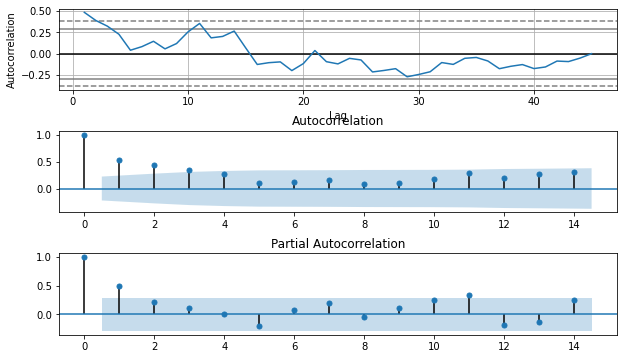

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

# ACF
autocorrelation_plot(mood_cutoff, ax=ax1) # pandas acf: cannot handle NaN
plot_acf(mood, lags=14, alpha=0.05, use_vlines = True, ax=ax2, missing="drop") # statsmodel acf

# PACF
plot_pacf(mood_cutoff, lags=14, alpha=0.05, use_vlines = True, ax=ax3) # statsmodel acf: cannot handle NaN
plt.show()

Arima try-out

In [10]:
p = 1 # found by acf
d = 0 # no differencing required because already stationary...  (apparantly?)
q = 1 # found by pacf

warnings.filterwarnings("ignore")

Test MSE:		 0.24376626533776774
Test r2:		 -0.02253774882383297
Test percentage correct: 0.6794871794871795


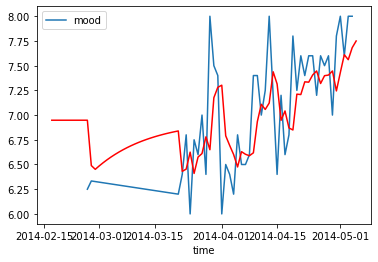

In [11]:
# Train model with whole series
model_fit = model_fit_ARIMA(mood, order=(p,d,q))

# Evaluate results
forecast = model_fit.forecast(len(mood))

# Adjust mood (fill NaNs with forecasted values) so we can get MSE for the present mood data
mood_mse = [y if pd.isna(x[0]) else x[0] for x,y in zip(mood.values, forecast)]
mse, r2, correct = evaluate(mood_mse, forecast)
print(f'Test MSE:\t\t {mse}')
print(f'Test r2:\t\t {r2}')
print(f'Test percentage correct: {correct}')
print

# Plot results
sns.lineplot(data=mood)
sns.lineplot(data=model_fit.fittedvalues, color='red')

Use ARIMA to train and test on unforeseen data. We are gonna check the following sets:
- full range, i.e with the long gap of NaNs at the beginning
- cutoff range, i.e without the long gap and without the first 2 values and without the last value
- dropna, i.e all the non-NaNs

Test MSE: 0.6544483598207276 	for 1, 0 and 1
Test r2: -7.1241865357055865
Test correct: 0.2


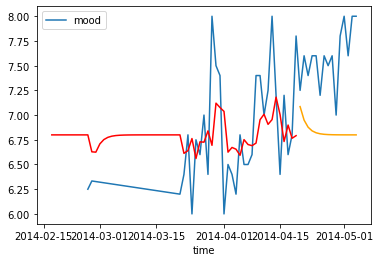

In [12]:
perform_ARIMA(mood, (p,d,q))

Test MSE: 0.4960313640274113 	for 1, 0 and 1
Test r2: -3.764950663087526
Test correct: 0.4


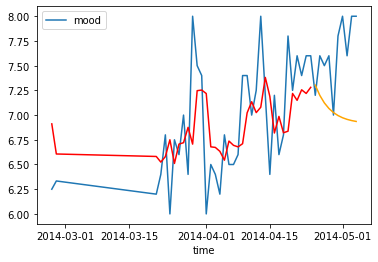

In [13]:
perform_ARIMA(mood_dropna, (p,d,q))

Test MSE: 0.5634167565931091 	for 1, 0 and 1
Test r2: -5.068717723941734
Test correct: 0.3333333333333333


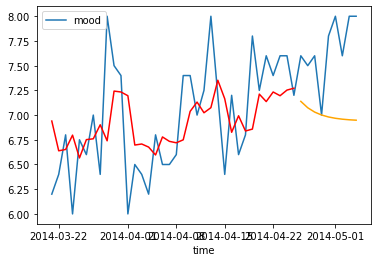

In [14]:
perform_ARIMA(mood_cutoff, (p,d,q))

They are not great. The dropna seems the best though.

Try different p,d,q values because it does not work well with the theoretically obtaines values (1,0,1)

In [15]:
p_values = [0,1,2,3]
d_values = [0,1,2]
q_values = [0,1,2]

MSE: 0.6659477458520975 			for 0, 0 and 0
r2: -7.266937534715696
Correct: 0.2


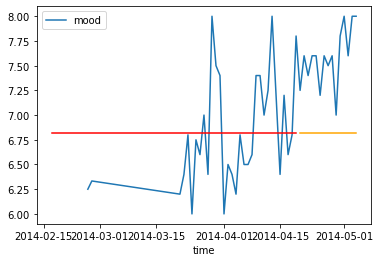

MSE: 0.6599634571589753 			for 0, 0 and 1
r2: -7.192649813007973
Correct: 0.2


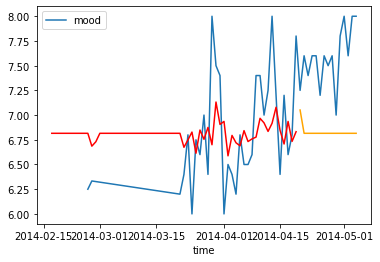

MSE: 0.6551077618888148 			for 0, 0 and 2
r2: -7.132372216550808
Correct: 0.2


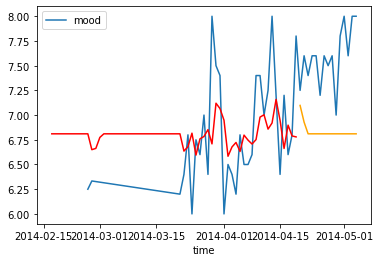

MSE: 0.12749999999999959 			for 0, 1 and 0
r2: -0.5827586206896507
Correct: 0.8


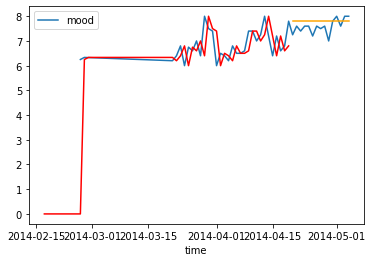

MSE: 0.312936279881885 			for 0, 1 and 1
r2: -2.884726233016505
Correct: 0.7333333333333333


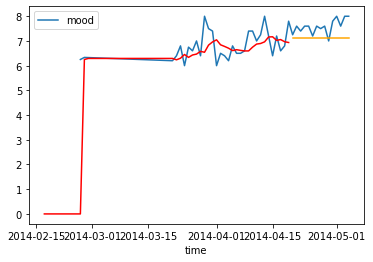

MSE: 0.3510911746321484 			for 0, 1 and 2
r2: -3.35837320233012
Correct: 0.3333333333333333


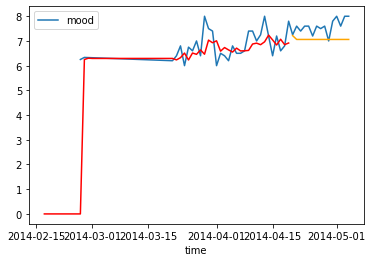

MSE: 84.86750000000038 			for 0, 2 and 0
r2: -1052.5275862069018
Correct: 0.0


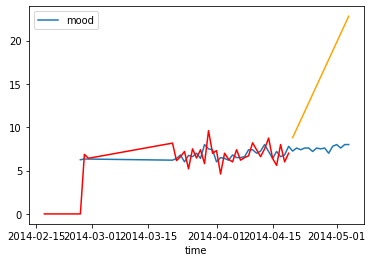

MSE: 0.2658776642272948 			for 0, 2 and 1
r2: -2.3005503145457302
Correct: 0.6666666666666666


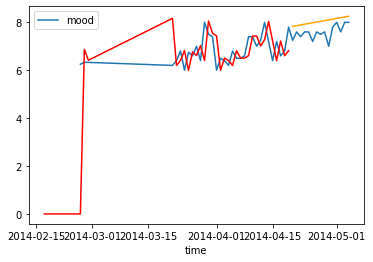

MSE: 0.14793820080570644 			for 0, 2 and 2
r2: -0.8364742168984254
Correct: 0.8


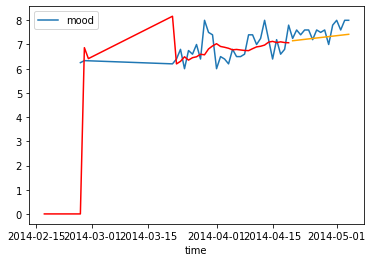

MSE: 0.6555128264376139 			for 1, 0 and 0
r2: -7.137400604053141
Correct: 0.2


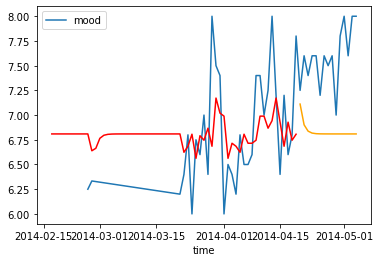

MSE: 0.6544483598207276 			for 1, 0 and 1
r2: -7.1241865357055865
Correct: 0.2


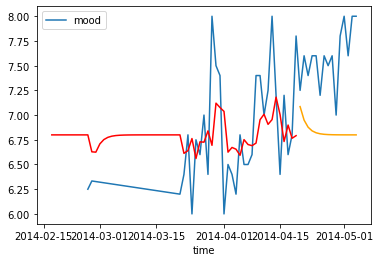

MSE: 0.6578351263264517 			for 1, 0 and 2
r2: -7.166229154397335
Correct: 0.2


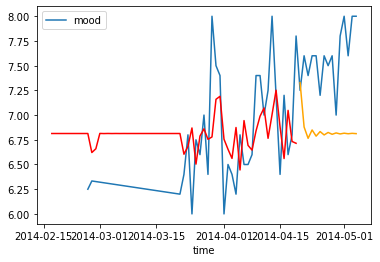

MSE: 0.08220007583533341 			for 1, 1 and 0
r2: -0.020414734507587573
Correct: 0.9333333333333333


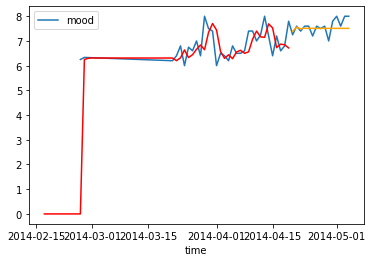

MSE: 0.3655243259015169 			for 1, 1 and 1
r2: -3.5375433560188325
Correct: 0.3333333333333333


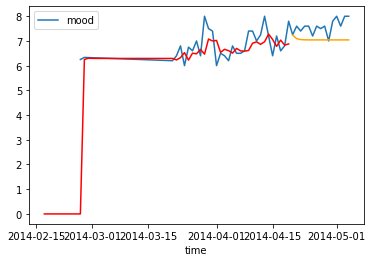

MSE: 0.3770542874323914 			for 1, 1 and 2
r2: -3.680673912953827
Correct: 0.4


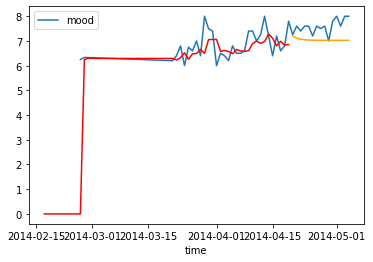

MSE: 39.06455369632145 			for 1, 2 and 0
r2: -483.9392872646802
Correct: 0.0


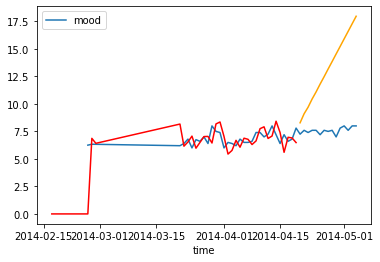

MSE: 0.07246922053739314 			for 1, 2 and 1
r2: 0.10038208988063646
Correct: 0.9333333333333333


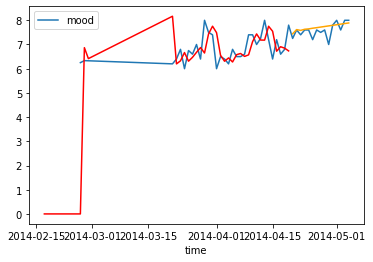

MSE: 0.11806996413353604 			for 1, 2 and 2
r2: -0.4656961064852756
Correct: 0.8666666666666667


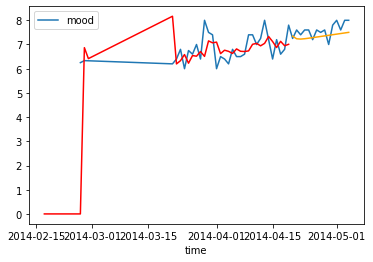

MSE: 0.6536246301817742 			for 2, 0 and 0
r2: -7.1139609263944426
Correct: 0.2


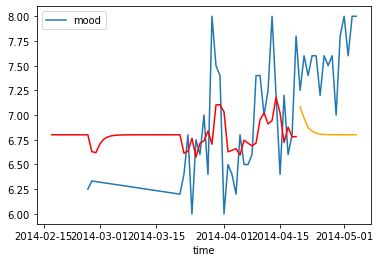

MSE: 0.653784317984875 			for 2, 0 and 1
r2: -7.115943257743279
Correct: 0.2


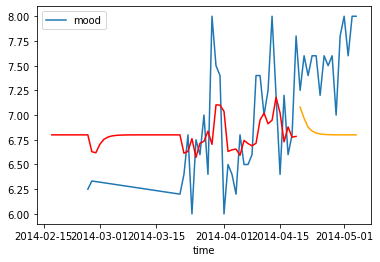

MSE: 0.6540170694778411 			for 2, 0 and 2
r2: -7.118832586621478
Correct: 0.2


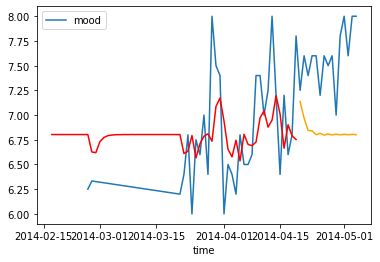

MSE: 0.13799562587892525 			for 2, 1 and 0
r2: -0.7130491488418313
Correct: 0.8


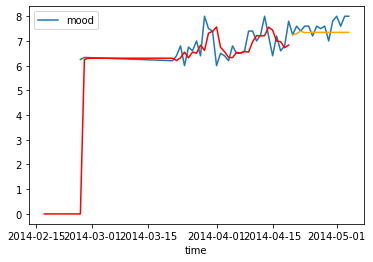

MSE: 0.37499834421065736 			for 2, 1 and 1
r2: -3.655151859166783
Correct: 0.4


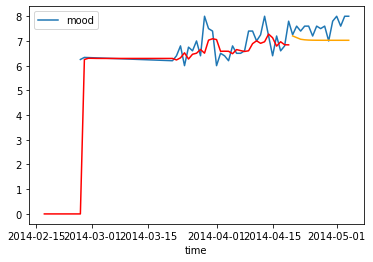

MSE: 0.36368512077328397 			for 2, 1 and 2
r2: -3.5147118440821474
Correct: 0.4


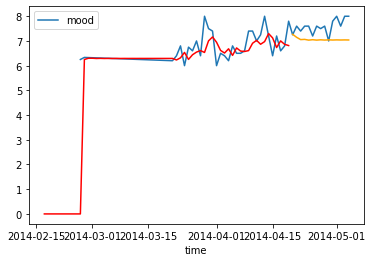

MSE: 11.71501782206438 			for 2, 2 and 0
r2: -144.42780744631654
Correct: 0.06666666666666667


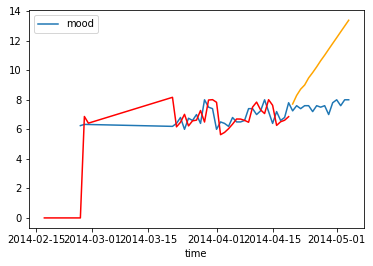

MSE: 0.06101042177970197 			for 2, 2 and 1
r2: 0.24262924687266485
Correct: 0.9333333333333333


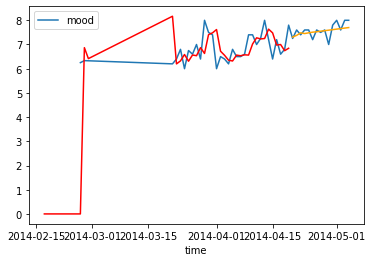

MSE: 0.07295287547595189 			for 2, 2 and 2
r2: 0.09437809753990722
Correct: 0.9333333333333333


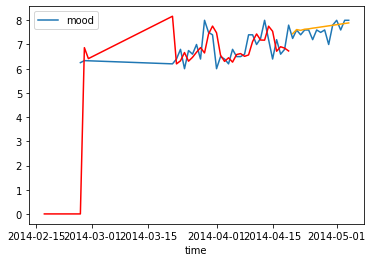

MSE: 0.653857170232651 			for 3, 0 and 0
r2: -7.116847630474291
Correct: 0.2


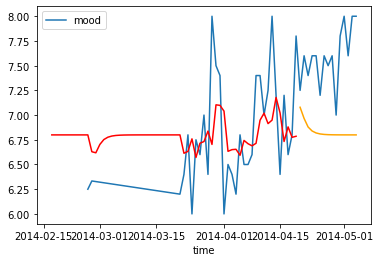

MSE: 0.6538644012361876 			for 3, 0 and 1
r2: -7.116937394656125
Correct: 0.2


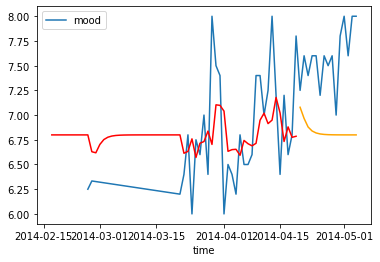

MSE: 0.5256833733425418 			for 3, 0 and 2
r2: -5.525724634597073
Correct: 0.4


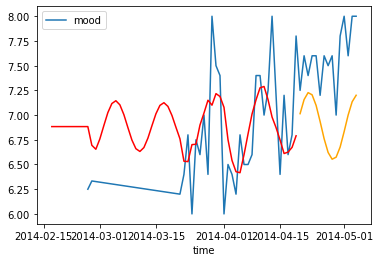

MSE: 0.17050235782456483 			for 3, 1 and 0
r2: -1.116580993684254
Correct: 0.7333333333333333


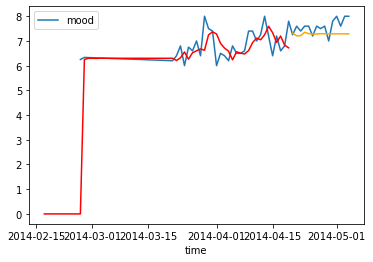

MSE: 0.3752187179011784 			for 3, 1 and 1
r2: -3.6578875325663542
Correct: 0.4


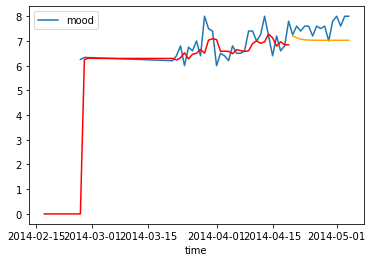

MSE: 0.36092255954245617 			for 3, 1 and 2
r2: -3.4804179805270437
Correct: 0.4


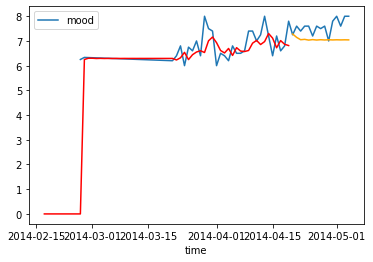

MSE: 7.740036322328504 			for 3, 2 and 0
r2: -95.08320951856078
Correct: 0.06666666666666667


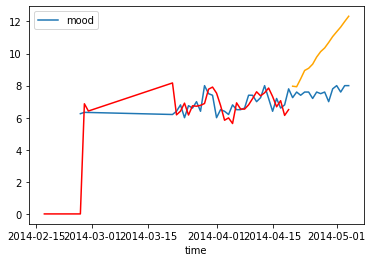

MSE: 0.07131311434195445 			for 3, 2 and 1
r2: 0.11473375299642719
Correct: 0.9333333333333333


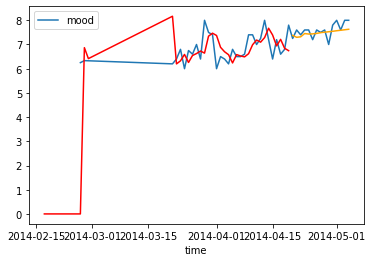

MSE: 0.06811566116945127 			for 3, 2 and 2
r2: 0.15442627513784601
Correct: 0.9333333333333333


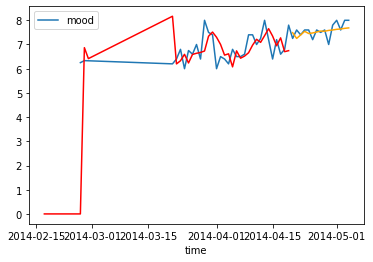

MSE: 0.6204873443189418 			for 0, 0 and 0
r2: -5.683440809818389
Correct: 0.1111111111111111


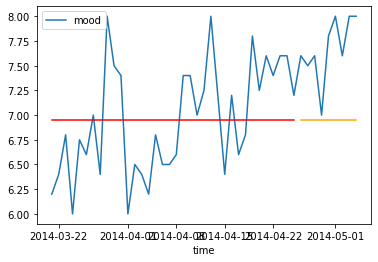

MSE: 0.6213055698056977 			for 0, 0 and 1
r2: -5.692254142853925
Correct: 0.1111111111111111


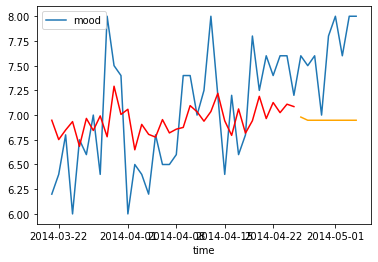

MSE: 0.6201330986926308 			for 0, 0 and 2
r2: -5.67962513219456
Correct: 0.1111111111111111


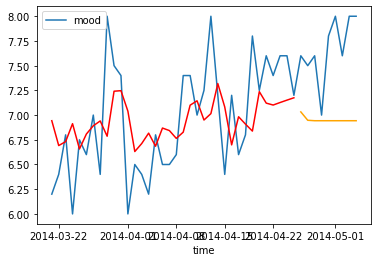

MSE: 0.3211111111111117 			for 0, 1 and 0
r2: -2.4587765957446868
Correct: 0.5555555555555556


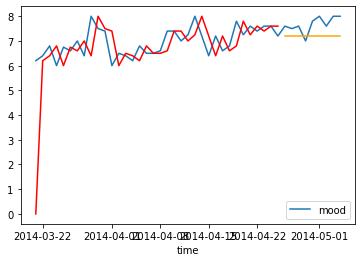

MSE: 0.17206217078833103 			for 0, 1 and 1
r2: -0.8533292332253739
Correct: 0.6666666666666666


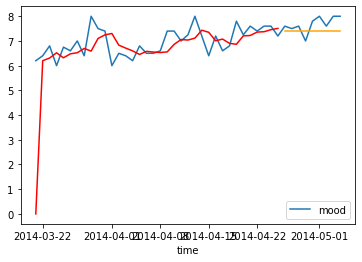

MSE: 0.21110985068361804 			for 0, 1 and 2
r2: -1.2739225937996088
Correct: 0.6666666666666666


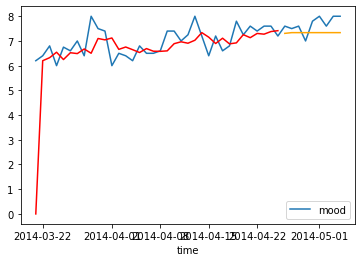

MSE: 7.663333334287568 			for 0, 2 and 0
r2: -81.54388298900173
Correct: 0.0


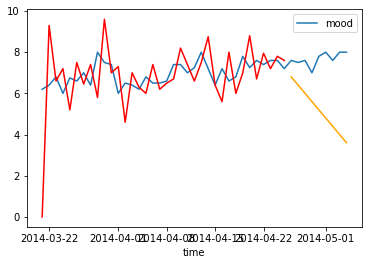

MSE: 0.1844215130714677 			for 0, 2 and 1
r2: -0.9864551274985216
Correct: 0.6666666666666666


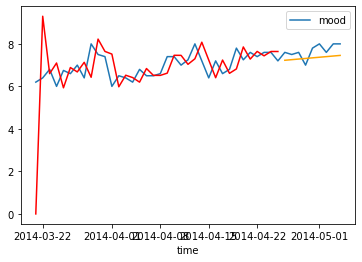

MSE: 0.07720755312735066 			for 0, 2 and 2
r2: 0.16837608998465392
Correct: 0.8888888888888888


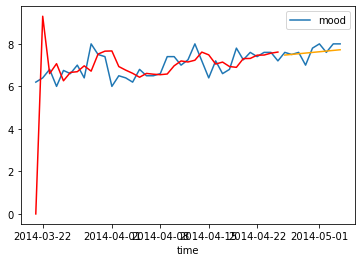

MSE: 0.6117909461451805 			for 1, 0 and 0
r2: -5.589769499702076
Correct: 0.1111111111111111


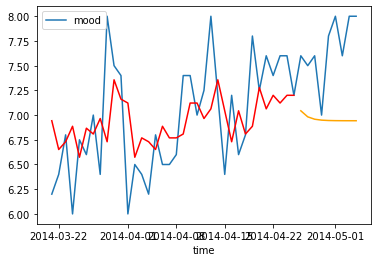

MSE: 0.5634167565931091 			for 1, 0 and 1
r2: -5.068717723941734
Correct: 0.3333333333333333


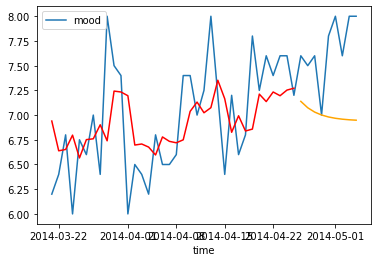

MSE: 0.5746169452576265 			for 1, 0 and 2
r2: -5.189358053971775
Correct: 0.3333333333333333


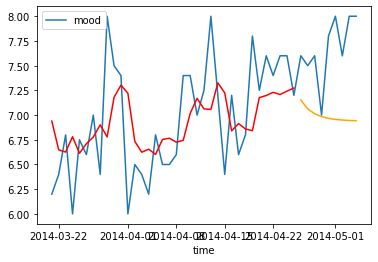

MSE: 0.21862596317427255 			for 1, 1 and 0
r2: -1.3548807203611801
Correct: 0.6666666666666666


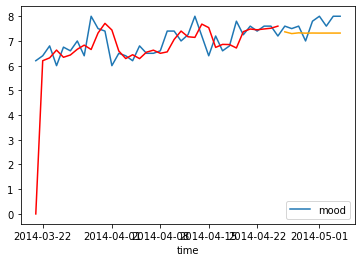

MSE: 0.2440748765206373 			for 1, 1 and 1
r2: -1.6289980050760136
Correct: 0.5555555555555556


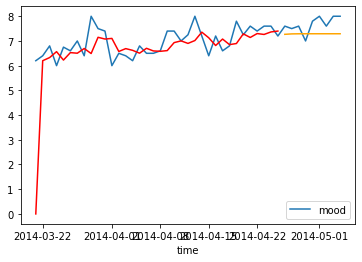

MSE: 0.2697134090943741 			for 1, 1 and 2
r2: -1.9051577309367422
Correct: 0.5555555555555556


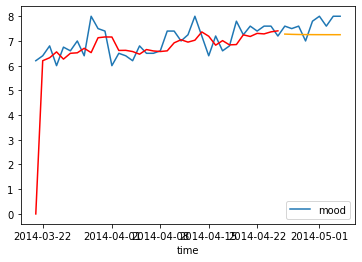

MSE: 3.361461643364608 			for 1, 2 and 0
r2: -35.20723312666665
Correct: 0.0


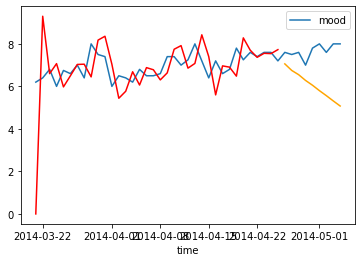

MSE: 0.10780391578943009 			for 1, 2 and 1
r2: -0.16118579507231878
Correct: 1.0


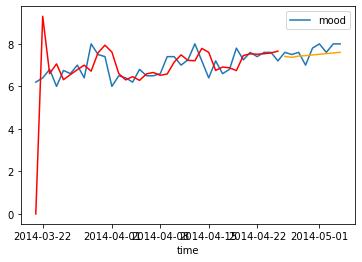

MSE: 0.09463468312737314 			for 1, 2 and 2
r2: -0.019336347515588326
Correct: 0.8888888888888888


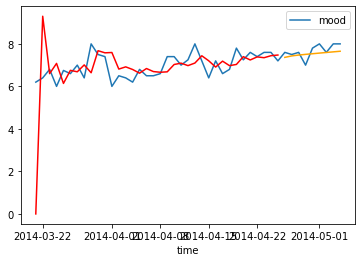

MSE: 0.5782845671412868 			for 2, 0 and 0
r2: -5.228863023729286
Correct: 0.3333333333333333


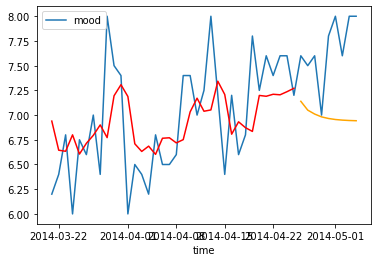

MSE: 0.5708733258617751 			for 2, 0 and 1
r2: -5.149034493989864
Correct: 0.3333333333333333


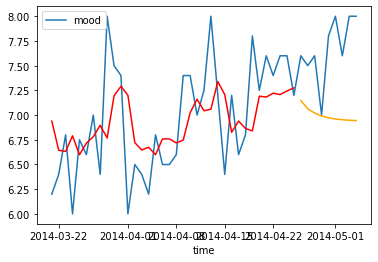

MSE: 0.5770823496076412 			for 2, 0 and 2
r2: -5.215913606146135
Correct: 0.3333333333333333


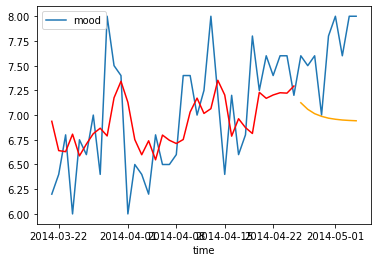

MSE: 0.1896433147414237 			for 2, 1 and 0
r2: -1.0427005976137393
Correct: 0.6666666666666666


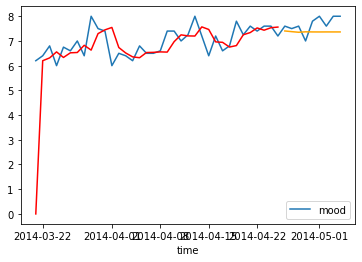

MSE: 0.27374637094308296 			for 2, 1 and 1
r2: -1.948597878509271
Correct: 0.5555555555555556


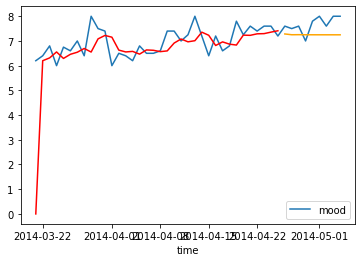

MSE: 0.2657768036408072 			for 2, 1 and 2
r2: -1.862755464748056
Correct: 0.5555555555555556


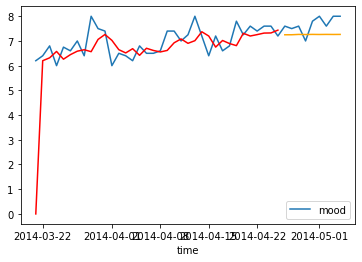

MSE: 1.389834008436781 			for 2, 2 and 0
r2: -13.970286527045113
Correct: 0.3333333333333333


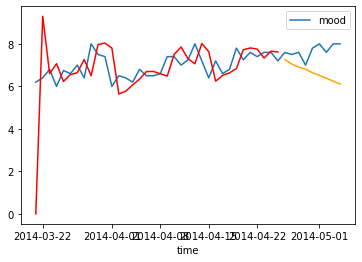

MSE: 0.09264724785107589 			for 2, 2 and 1
r2: 0.0020708675615496164
Correct: 0.8888888888888888


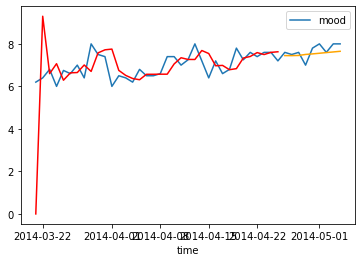

MSE: 0.11298633794076898 			for 2, 2 and 2
r2: -0.217007097500304
Correct: 1.0


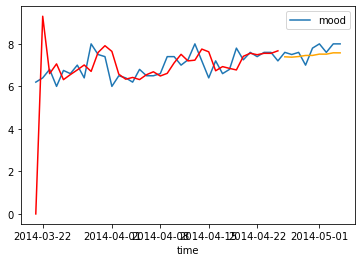

MSE: 0.5697278720357407 			for 3, 0 and 0
r2: -5.136696494001995
Correct: 0.3333333333333333


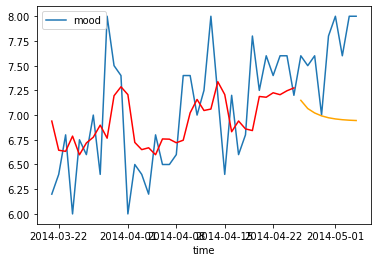

MSE: 0.5694946377313828 			for 3, 0 and 1
r2: -5.134184262798138
Correct: 0.3333333333333333


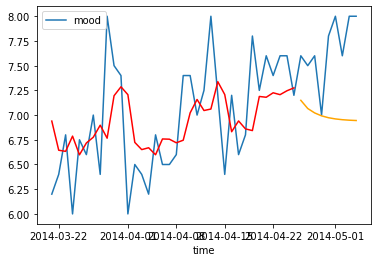

MSE: 0.5522420003583073 			for 3, 0 and 2
r2: -4.948351333646661
Correct: 0.3333333333333333


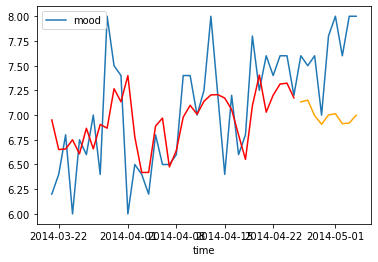

MSE: 0.1778163862840757 			for 3, 1 and 0
r2: -0.91530947992156
Correct: 0.6666666666666666


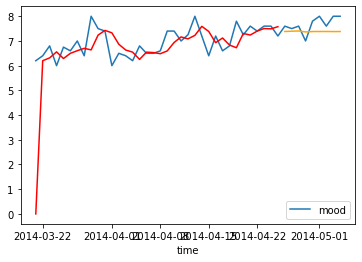

MSE: 0.274064352380814 			for 3, 1 and 1
r2: -1.9520229445273847
Correct: 0.5555555555555556


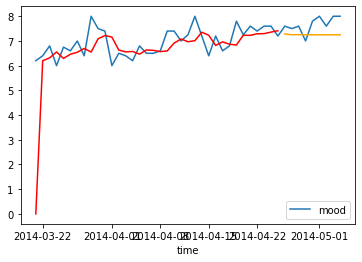

MSE: 0.27193342051615316 			for 3, 1 and 2
r2: -1.9290700880064366
Correct: 0.5555555555555556


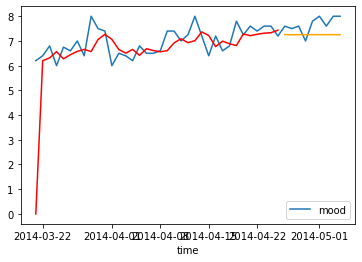

MSE: 0.8872440473643246 			for 3, 2 and 0
r2: -8.556751042089134
Correct: 0.3333333333333333


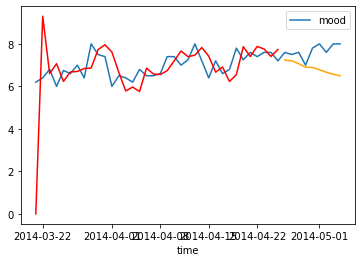

MSE: 0.0816173788179037 			for 3, 2 and 1
r2: 0.12087663773268642
Correct: 0.8888888888888888


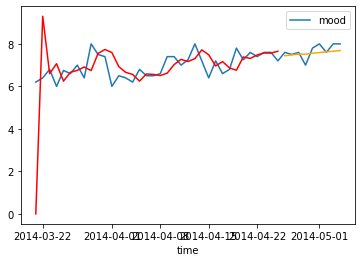

MSE: 0.08611575276691151 			for 3, 2 and 2
r2: 0.07242340769683087
Correct: 1.0


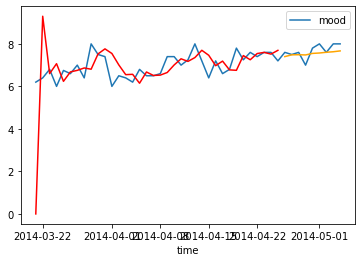

MSE: 0.6239352955458067 			for 0, 0 and 0
r2: -4.993614750680182
Correct: 0.2


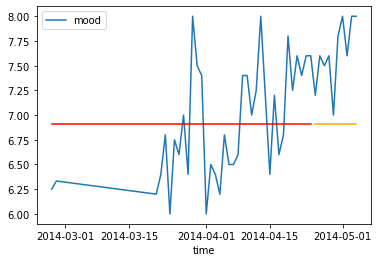

MSE: 0.6176516118648271 			for 0, 0 and 1
r2: -4.933252755665968
Correct: 0.2


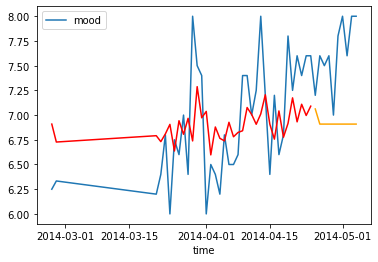

MSE: 0.6014008626130402 			for 0, 0 and 2
r2: -4.777145654303942
Correct: 0.2


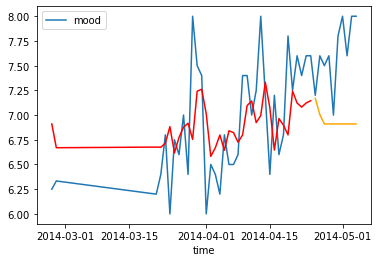

MSE: 0.10500000000000001 			for 0, 1 and 0
r2: -0.008645533141210748
Correct: 0.9


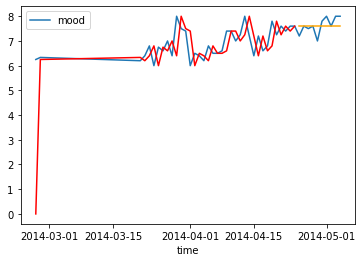

MSE: 0.11560735210094841 			for 0, 1 and 1
r2: -0.11054132661814076
Correct: 0.9


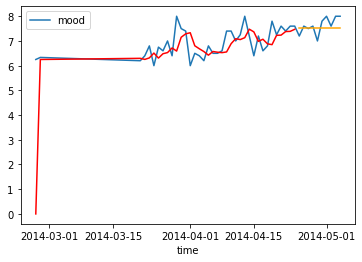

MSE: 0.13966148330242883 			for 0, 1 and 2
r2: -0.34160886937972035
Correct: 0.7


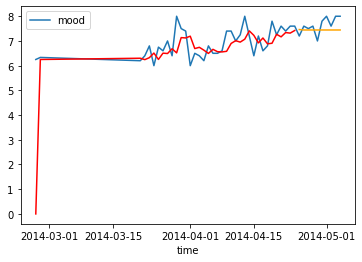

MSE: 0.10499999997933744 			for 0, 2 and 0
r2: -0.008645532942723078
Correct: 0.9


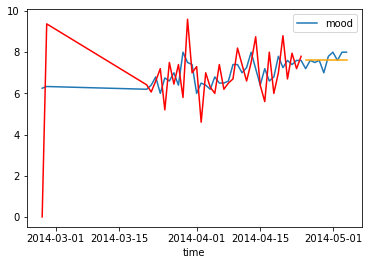

MSE: 0.09989118560952744 			for 0, 2 and 1
r2: 0.04043049366448159
Correct: 0.9


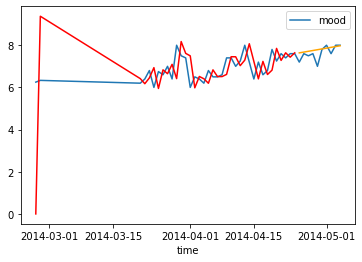

MSE: 0.09201519884831344 			for 0, 2 and 2
r2: 0.1160883876242702
Correct: 0.9


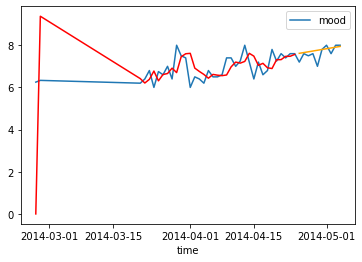

MSE: 0.5867603478265423 			for 1, 0 and 0
r2: -4.636506703425
Correct: 0.2


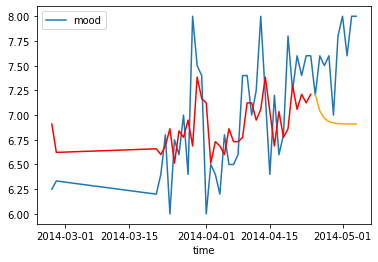

MSE: 0.4960313640274113 			for 1, 0 and 1
r2: -3.764950663087526
Correct: 0.4


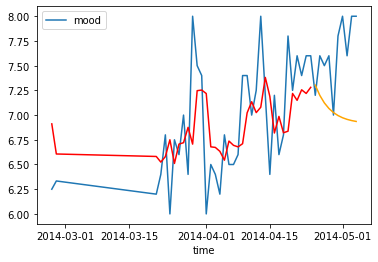

MSE: 0.5169845354813034 			for 1, 0 and 2
r2: -3.9662299277742905
Correct: 0.4


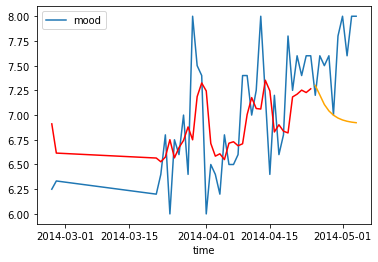

MSE: 0.10500000000000001 			for 1, 1 and 0
r2: -0.008645533141210748
Correct: 0.9


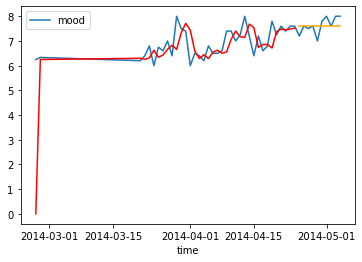

MSE: 0.16876808813494265 			for 1, 1 and 1
r2: -0.6212112212770673
Correct: 0.7


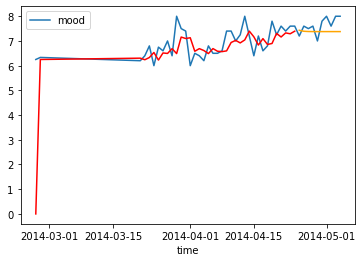

MSE: 0.18784480127204714 			for 1, 1 and 2
r2: -0.804464949779512
Correct: 0.7


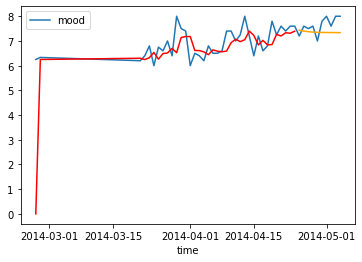

MSE: 0.24698204476960495 			for 1, 2 and 0
r2: -1.3725460592661385
Correct: 0.7


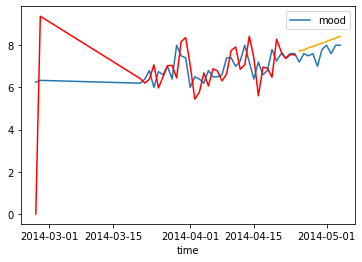

MSE: 0.10421301572846826 			for 1, 2 and 1
r2: -0.0010856458066117458
Correct: 0.9


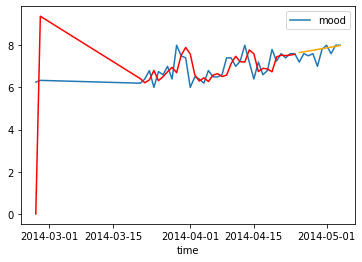

MSE: 0.0799948970424992 			for 1, 2 and 2
r2: 0.23155718499040145
Correct: 0.9


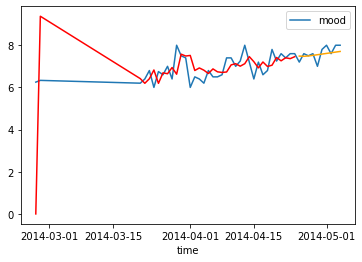

MSE: 0.5240816693631705 			for 2, 0 and 0
r2: -4.034406045755722
Correct: 0.4


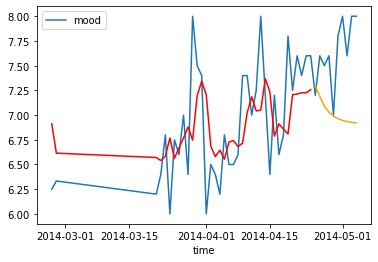

MSE: 0.5097453370147351 			for 2, 0 and 1
r2: -3.8966891163759394
Correct: 0.4


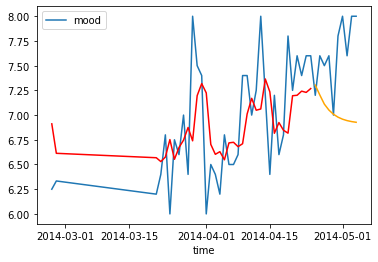

MSE: 0.5078367928032799 			for 2, 0 and 2
r2: -3.8783553583408263
Correct: 0.4


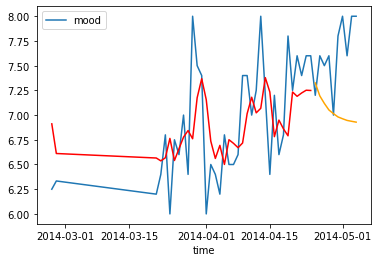

MSE: 0.10571530689940697 			for 2, 1 and 0
r2: -0.01551687703561
Correct: 0.9


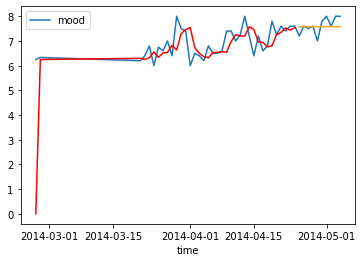

MSE: 0.1913554702221368 			for 2, 1 and 1
r2: -0.8381889550637547
Correct: 0.7


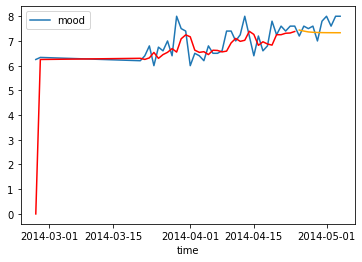

MSE: 0.18371150481386084 			for 2, 1 and 2
r2: -0.7647598925442931
Correct: 0.7


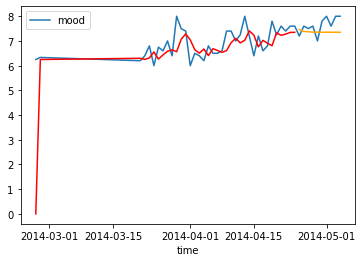

MSE: 0.10827371729688817 			for 2, 2 and 0
r2: -0.0400933457914332
Correct: 0.9


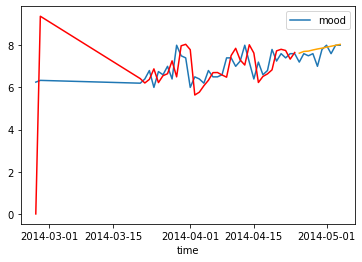

MSE: 0.09861301093321097 			for 2, 2 and 1
r2: 0.052708828691537035
Correct: 0.9


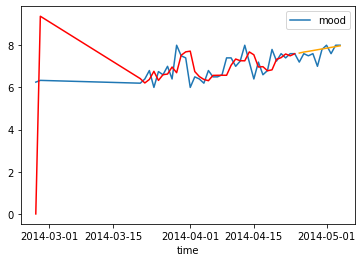

MSE: 0.10917739090319803 			for 2, 2 and 2
r2: -0.048774168138309815
Correct: 0.9


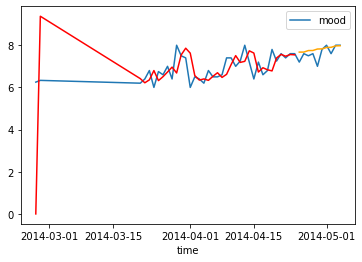

MSE: 0.5111790215591169 			for 3, 0 and 0
r2: -3.9104613022009325
Correct: 0.4


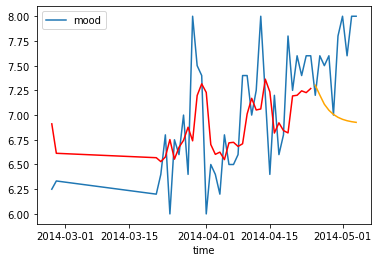

MSE: 0.5091226346181609 			for 3, 0 and 1
r2: -3.8907073450351684
Correct: 0.4


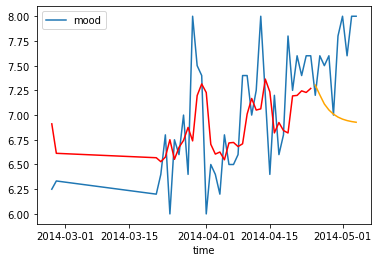

MSE: 0.5084106473949717 			for 3, 0 and 2
r2: -3.8838678904416124
Correct: 0.4


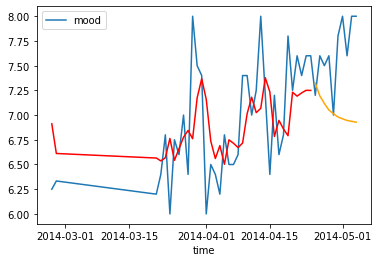

MSE: 0.10805757404479284 			for 3, 1 and 0
r2: -0.038017041736722934
Correct: 0.9


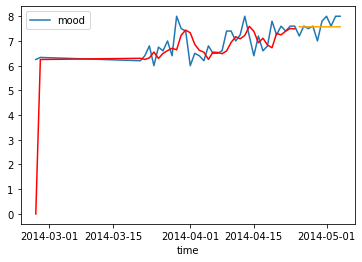

MSE: 0.1914061245279568 			for 3, 1 and 1
r2: -0.83867554781899
Correct: 0.7


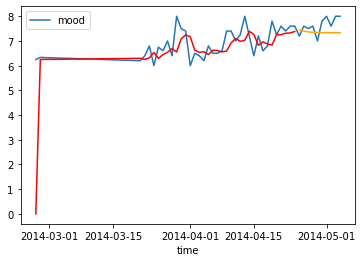

MSE: 0.18843966351392066 			for 3, 1 and 2
r2: -0.8101792844757032
Correct: 0.7


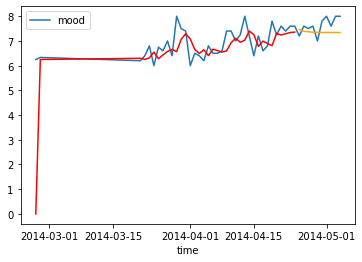

MSE: 0.17805466682312274 			for 3, 2 and 0
r2: -0.7104194699627551
Correct: 0.7


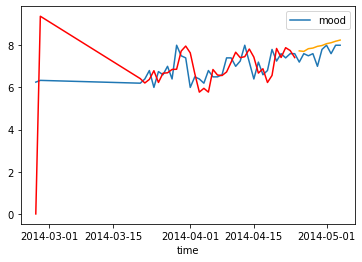

MSE: 0.1021862527646579 			for 3, 2 and 1
r2: 0.018383739052277415
Correct: 0.9


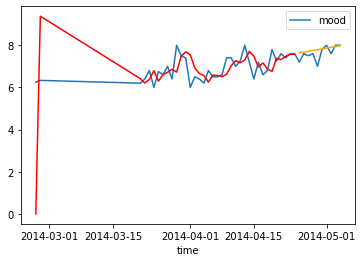

MSE: 0.11247457956924409 			for 3, 2 and 2
r2: -0.08044745023289268
Correct: 0.9


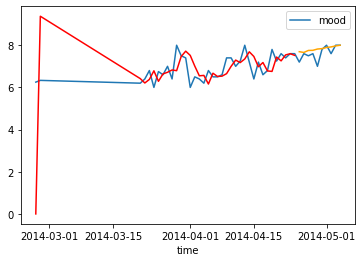

In [16]:
# pdq analysis on full mood range
pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values)
pdq_results.sort_values('mse', inplace = True)
pdq_results = pdq_results.reset_index()

# pdq analysis on cutoff mood range
pdq_results_cutoff = do_experiment_ARIMA_find_pdq_values(mood_cutoff, p_values, d_values, q_values)
pdq_results_cutoff.sort_values('mse', inplace = True)
pdq_results_cutoff = pdq_results_cutoff.reset_index()

# pdq analysis on dropna mood range
pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values)
pdq_results_dropna.sort_values('mse', inplace = True)
pdq_results_dropna = pdq_results_dropna.reset_index()

In [17]:
dfs_pdq = [pdq_results, pdq_results_cutoff, pdq_results_dropna]

# Combine dataframes
df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)
              
# Drop unused index columns
df_pdq = df_pdq.loc[:,~df_pdq.columns.str.startswith('index')]

# Show results                                   
print('1=full range, 2=cutoff, 3=dropna')
df_pdq

1=full range, 2=cutoff, 3=dropna


p1  d1  q1       mse1          r21     corr1  tr_na1  tr1  tst1  p2  ...  \
0    2   2   1   0.061010     0.242629  0.933333      32   62    15   0  ...   
1    3   2   2   0.068116     0.154426  0.933333      32   62    15   3  ...   
2    3   2   1   0.071313     0.114734  0.933333      32   62    15   3  ...   
3    1   2   1   0.072469     0.100382  0.933333      32   62    15   2  ...   
4    2   2   2   0.072953     0.094378  0.933333      32   62    15   1  ...   
5    1   1   0   0.082200    -0.020415  0.933333      32   62    15   1  ...   
6    1   2   2   0.118070    -0.465696  0.866667      32   62    15   2  ...   
7    0   1   0   0.127500    -0.582759  0.800000      32   62    15   0  ...   
8    2   1   0   0.137996    -0.713049  0.800000      32   62    15   3  ...   
9    0   2   2   0.147938    -0.836474  0.800000      32   62    15   0  ...   
10   3   1   0   0.170502    -1.116581  0.733333      32   62    15   2  ...   
11   0   2   1   0.265878    -2.300550  0.666667      32   62    15   0  ...   
12   0   1   1   0.312936    -2.884726  0.733333      32   62    15   1  ...   
13   0   1   2   0.351091    -3.358373  0.333333      32   62    15   1  ...   
14   3   1   2   0.360923    -3.480418  0.400000      32   62    15   2  ...   
15   2   1   2   0.363685    -3.514712  0.400000      32   62    15   1  ...   
16   1   1   1   0.365524    -3.537543  0.333333      32   62    15   3  ...   
17   2   1   1   0.374998    -3.655152  0.400000      32   62    15   2  ...   
18   3   1   1   0.375219    -3.657888  0.400000      32   62    15   3  ...   
19   1   1   2   0.377054    -3.680674  0.400000      32   62    15   0  ...   
20   3   0   2   0.525683    -5.525725  0.400000      32   62    15   3  ...   
21   2   0   0   0.653625    -7.113961  0.200000      32   62    15   1  ...   
22   2   0   1   0.653784    -7.115943  0.200000      32   62    15   3  ...   
23   3   0   0   0.653857    -7.116848  0.200000      32   62    15   3  ...   
24   3   0   1   0.653864    -7.116937  0.200000      32   62    15   2  ...   
25   2   0   2   0.654017    -7.118833  0.200000      32   62    15   1  ...   
26   1   0   1   0.654448    -7.124187  0.200000      32   62    15   2  ...   
27   0   0   2   0.655108    -7.132372  0.200000      32   62    15   2  ...   
28   1   0   0   0.655513    -7.137401  0.200000      32   62    15   1  ...   
29   1   0   2   0.657835    -7.166229  0.200000      32   62    15   0  ...   
30   0   0   1   0.659963    -7.192650  0.200000      32   62    15   0  ...   
31   0   0   0   0.665948    -7.266938  0.200000      32   62    15   0  ...   
32   3   2   0   7.740036   -95.083210  0.066667      32   62    15   3  ...   
33   2   2   0  11.715018  -144.427807  0.066667      32   62    15   2  ...   
34   1   2   0  39.064554  -483.939287  0.000000      32   62    15   1  ...   
35   0   2   0  84.867500 -1052.527586  0.000000      32   62    15   0  ...   

    tst2  p3  d3  q3      mse3       r23  corr3  tr_na3  tr3  tst3  
0      9   1   2   2  0.079995  0.231557    0.9      37   37    10  
1      9   0   2   2  0.092015  0.116088    0.9      37   37    10  
2      9   2   2   1  0.098613  0.052709    0.9      37   37    10  
3      9   0   2   1  0.099891  0.040430    0.9      37   37    10  
4      9   3   2   1  0.102186  0.018384    0.9      37   37    10  
5      9   1   2   1  0.104213 -0.001086    0.9      37   37    10  
6      9   0   2   0  0.105000 -0.008646    0.9      37   37    10  
7      9   0   1   0  0.105000 -0.008646    0.9      37   37    10  
8      9   1   1   0  0.105000 -0.008646    0.9      37   37    10  
9      9   2   1   0  0.105715 -0.015517    0.9      37   37    10  
10     9   3   1   0  0.108058 -0.038017    0.9      37   37    10  
11     9   2   2   0  0.108274 -0.040093    0.9      37   37    10  
12     9   2   2   2  0.109177 -0.048774    0.9      37   37    10  
13     9   3   2   2  0.112475 -0.080447    0.9      37   37    10  
14     9

Unexpected results to me, I would not have expected that the full range (with a very long gap between the first days and the rest of the days) would perform better than the cutoff-range or the ranges with NaN dropped.

So it seems like it's not necessary to cut off the period or remove NaNs? We still do a further analysis of this though because it seems unexpected.

Test MSE: 0.06101042177970197 	for 2, 2 and 1
Test r2: 0.24262924687266485
Test correct: 0.9333333333333333


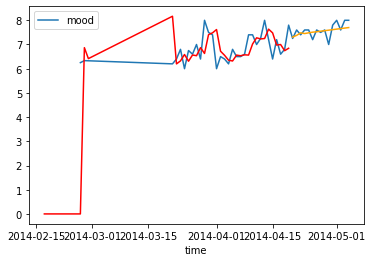

Test MSE: 0.07720755312735066 	for 0, 2 and 2
Test r2: 0.16837608998465392
Test correct: 0.8888888888888888


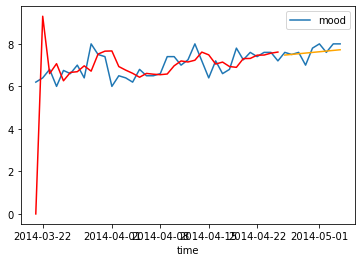

Test MSE: 0.0799948970424992 	for 1, 2 and 2
Test r2: 0.23155718499040145
Test correct: 0.9


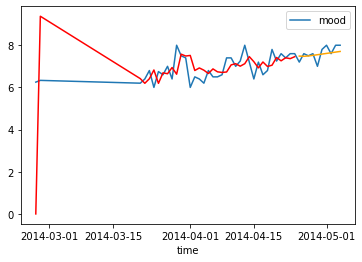

In [18]:
perform_ARIMA(mood, (2,2,1))
perform_ARIMA(mood_cutoff, (0,2,2))
perform_ARIMA(mood_dropna, (1,2,2))

In [19]:
print(f'Full range has {df_pdq["tr_na1"][0]} non-NaN training values (out of {df_pdq["tr1"][0]}) and {df_pdq["tst1"][0]} test values')
print(f'Cutoff range has {df_pdq["tr_na2"][0]} non-NaN training values (out of {df_pdq["tr2"][0]}) and {df_pdq["tst2"][0]} test values')
print(f'Dropnan range has {df_pdq["tr_na3"][0]} non-NaN training values (out of {df_pdq["tr3"][0]}) and {df_pdq["tst3"][0]} test values')

Full range has 32 non-NaN training values (out of 62) and 15 test values
Cutoff range has 36 non-NaN training values (out of 36) and 9 test values
Dropnan range has 37 non-NaN training values (out of 37) and 10 test values


The full range has less non-NaN values to train on and more values to test on than the cutoff/dropna range. Makes it even weirder for me that it performs better.

But on the other hand: this might not even be a big problem. Let's see how many persons even have missing mood data. 

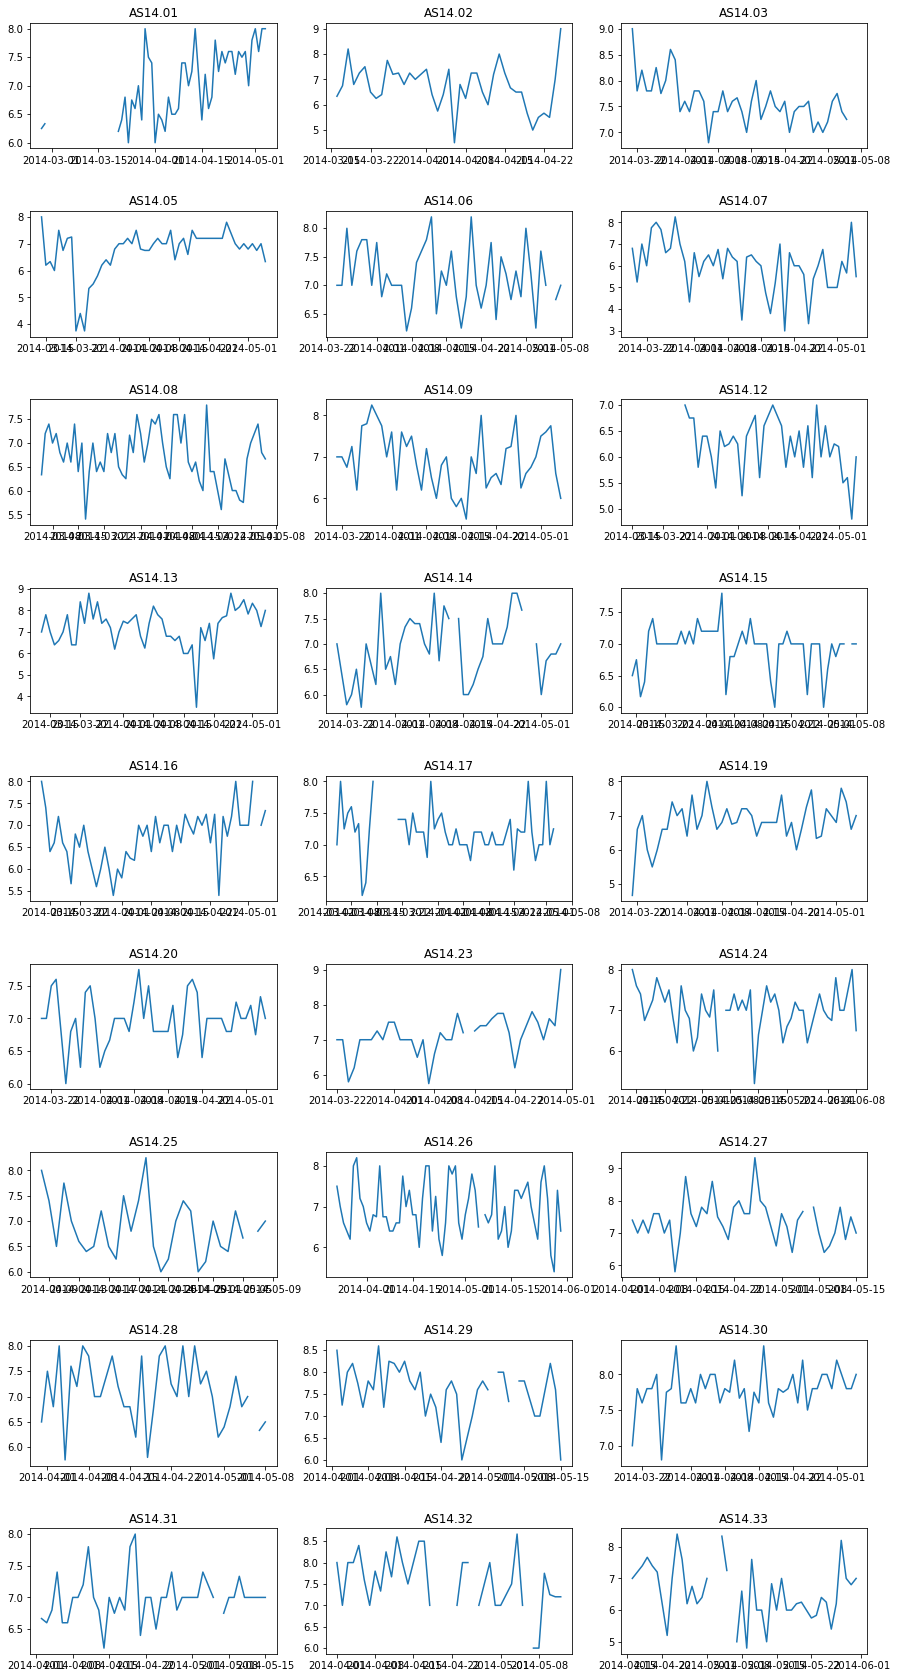

In [20]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(df.id.unique()) / 3)), ncols=3)
fig.set_figheight(30)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)

# Plot mood for each person
for ax, person in zip(axes.flatten(), df.id.unique()):
    mood = getPersonMoodArimaSet(df, person)
    ax.set(title=person)
    ax.plot(mood)

Not a lot, so this may not be relevant. We can probably just use ARIMA on the full set. For reference, the following persons have some big chunks of missing data:
- AS14.01 in the beginning
- AS14.17 in the beginning
- AS14.32 in the middle

Furthermore, some persons have small gaps in the end at the test set. Will look into this later.

For the sake of completeness, we will try all 2 sets on each person and see which dataset performs best.

In [21]:
df_results = pd.DataFrame(columns=df_pdq.columns[0:18], index=df.id.unique()) # init

# Do p,d,q experiment for each person, for each dataset
for person in df.id.unique():

    # Get mood set
    mood = getPersonMoodArimaSet(df, person)
    
    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Results for complete set
    pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values, doPrint=False)
    pdq_results.sort_values('mse', inplace = True)
    pdq_results = pdq_results.reset_index()

    # Results for set with dropped NaN
    pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values, doPrint=False)
    pdq_results_dropna.sort_values('mse', inplace = True)
    pdq_results_dropna = pdq_results_dropna.reset_index()
    
    # Get best results
    dfs_pdq = [pdq_results, pdq_results_dropna]
    df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
    df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)

    # Save best orders and their mse 
    df_results.loc[person] = df_pdq.loc[0]

In [22]:
df_results.to_csv('results/arima_preliminary.csv')

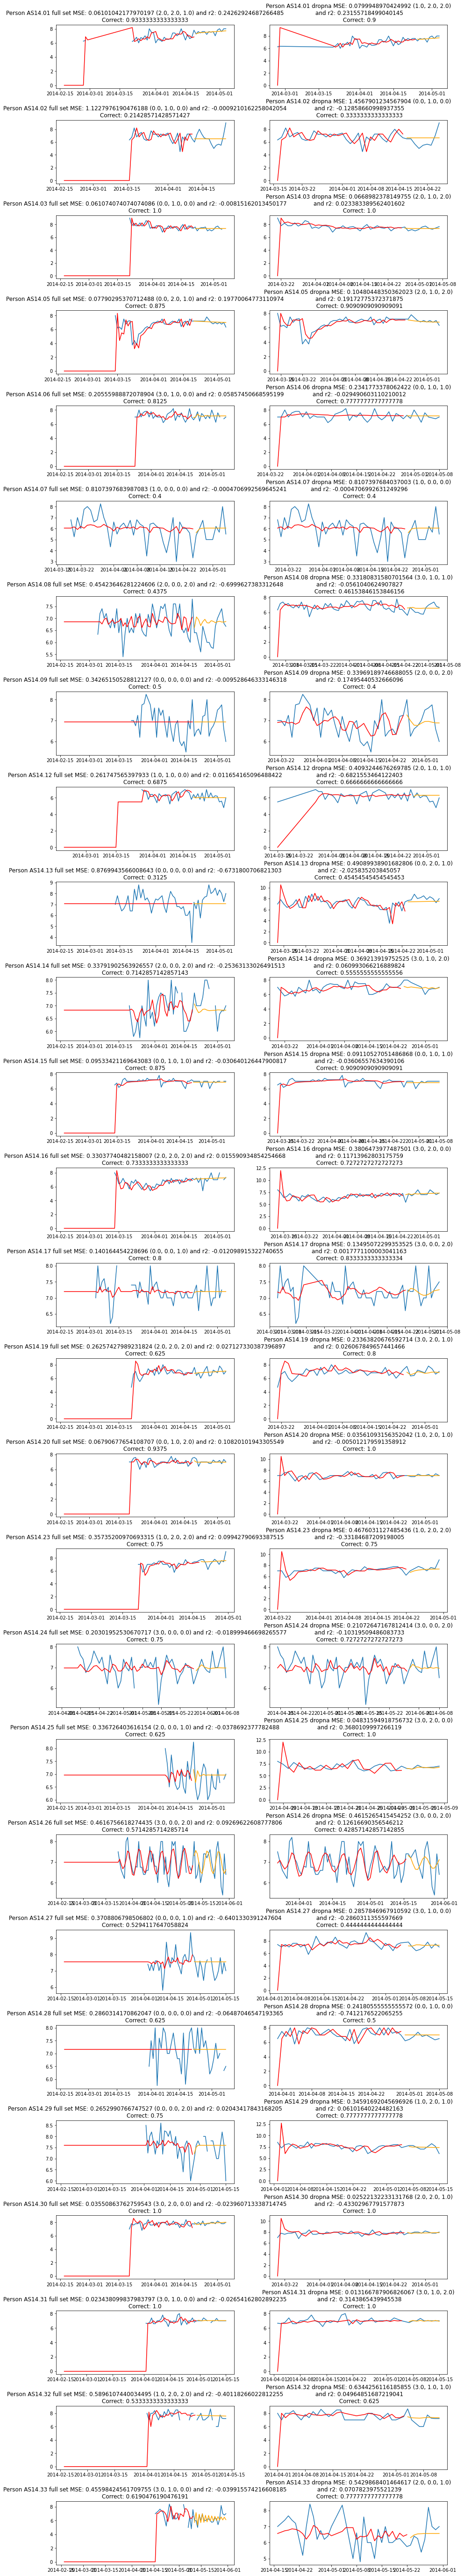

In [23]:
# Plotting stuff
fig, axes = plt.subplots(nrows=int(len(df.id.unique())), ncols=2)
fig.set_figheight(100)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)
axs = axes.flatten()

# Plot arima fitted values and forecasting for each person
for i, person in enumerate(df.id.unique()):
    
    # Get mood set
    mood = getPersonMoodArimaSet(df, person)

    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Get training and test sets
    train, test = get_train_set_set(mood, perc_train)
    train_dropna, test_dropna = get_train_set_set(mood_dropna, perc_train)
    
    # Get arima orders
    pdq = (df_results.loc[person].p1, df_results.loc[person].d1, df_results.loc[person].q1)
    pdq_dropna = (df_results.loc[person].p2, df_results.loc[person].d2, df_results.loc[person].q2)
    
    # Train the models
    model_fit = model_fit_ARIMA(train, order=pdq)
    model_fit_dropna = model_fit_ARIMA(train_dropna, order=pdq_dropna)

    # Forecast and check accuracy
    forecast = model_fit.forecast(len(test))
    mse, r2, correct = evaluate(test.values, forecast)
    forecast_dropna = model_fit_dropna.forecast(len(test_dropna))
    mse_dropna, r2_dropna, correct_dropna = evaluate(test_dropna.values, forecast_dropna)

    # Make axes
    ax = axs[i*2]
    ax_dropna = axs[i*2+1]
    
    # Plot full range
    ax.set_title(f'Person {person} full set MSE: {mse} {pdq} and r2: {r2}\nCorrect: {correct}')
    ax.plot(mood)
    ax.plot(model_fit.fittedvalues, color='red')
    ax.plot(test.index, forecast, color='orange')
    
    # Plot dropped NaN
    ax_dropna.set_title(f'Person {person} dropna MSE: {mse_dropna} {pdq_dropna}\n and r2: {r2_dropna}\n Correct: {correct_dropna}')
    ax_dropna.plot(mood_dropna)
    ax_dropna.plot(model_fit_dropna.fittedvalues, color='red')
    ax_dropna.plot(test_dropna.index, forecast_dropna, color='orange')

Let's analyse which mood dataset performs better and what the training / test sets look like.

In [24]:
df_results['best'] = np.where(df_results['mse1'] < df_results['mse2'], 'full', 'nan')
df_results['diff'] =  np.where(df_results['mse1'] < df_results['mse2'], df_results['mse2'] - df_results['mse1'], df_results['mse1'] - df_results['mse2'])

print(f'Mean MSE of full range is \t{df_results["mse1"].mean()}')
print(f'Mean MSE of dropnan range is \t{df_results["mse2"].mean()}')

df_results

Mean MSE of full range is 	0.3294265655482059
Mean MSE of dropnan range is 	0.3276953769352257


p1 d1 q1       mse1          r21     corr1 tr_na1 tr1 tst1 p2 d2 q2  \
AS14.01  2  2  1  0.0610104     0.242629  0.933333     32  62   15  1  2  2   
AS14.02  0  1  0     1.1228 -0.000921016  0.214286     27  54   14  0  1  0   
AS14.03  0  1  0  0.0610741  -0.00815162         1     32  64   15  2  1  2   
AS14.05  0  2  1   0.077903     0.197701     0.875     37  61   16  2  1  2   
AS14.06  3  1  0    0.20556    0.0585745    0.8125     29  64   16  0  1  1   
AS14.07  1  0  0    0.81074 -0.000470699       0.4     38  40   10  1  0  0   
AS14.08  2  0  2   0.454236    -0.699963    0.4375     46  62   16  3  1  1   
AS14.09  0  0  0   0.342652  -0.00952865       0.5     30  62   16  2  0  2   
AS14.12  1  1  0   0.261748    0.0116542    0.6875     25  60   16  2  1  1   
AS14.13  0  0  0   0.876994     -0.67318    0.3125     37  61   16  0  2  1   
AS14.14  2  0  2   0.337919    -0.253631  0.714286     30  62   14  3  1  2   
AS14.15  0  1  1  0.0953342   -0.0306401     0.875     39  64   16  0  1  1   
AS14.16  2  2  2   0.330377    0.0155909  0.733333     38  62   15  3  2  0   
AS14.17  0  0  1   0.140164   -0.0120989       0.8     41  62   15  3  0  2   
AS14.19  2  2  2   0.262574    0.0271273     0.625     30  62   16  3  2  1   
AS14.20  0  1  2  0.0679068     0.108201    0.9375     31  62   16  1  2  1   
AS14.23  1  2  2   0.357352    0.0994279      0.75     27  61   12  1  2  2   
AS14.24  3  0  0    0.20302   -0.0189995      0.75     43  49   12  3  0  2   
AS14.25  2  0  1   0.336726   -0.0378692     0.625     14  64   16  3  2  0   
AS14.26  3  0  2   0.461676    0.0926962  0.571429     47  82   21  3  0  2   
AS14.27  0  0  1   0.370881    -0.640133  0.529412     25  70   17  3  1  0   
AS14.28  0  0  0   0.286031   -0.0648705     0.625     22  64   16  0  1  0   
AS14.29  0  0  2   0.265299    0.0204342      0.75     26  70   16  1  2  1   
AS14.30  3  2  0  0.0355086   -0.0239607         1     31  62   16  2  2  1   
AS14.31  3  1  0  0.0234381   -0.0265416         1     28  72   15  3  1  2   
AS14.32  1  2  2   0.589611    -0.401183  0.533333     22  69   15  3  1  1   
AS14.33  3  1  0   0.455984   -0.0399156  0.619048     22  83   21  2  0  1   

              mse2          r22     corr2 tr_na2 tr2 tst2  best         diff  
AS14.01  0.0799949     0.231557       0.9     37  37   10  full    0.0189845  
AS14.02    1.45679    -0.128587  0.333333     32  32    9  full     0.333993  
AS14.03  0.0668982    0.0233834         1     37  37   10  full   0.00582416  
AS14.05   0.104804     0.191728  0.909091     42  42   11  full    0.0269015  
AS14.06   0.234177   -0.0294906  0.777778     36  36    9  full    0.0286174  
AS14.07    0.81074 -0.000470699       0.4     38  38   10  full  4.99201e-12  
AS14.08   0.331808   -0.0561041  0.461538     49  49   13   nan     0.122428  
AS14.09   0.339692     0.174954       0.4     36  36   10   nan   0.00295961  
AS14.12   0.409324    -0.682155  0.666667     32  32    9  full     0.147577  
AS14.13   0.490899     -2.02584  0.454545     42  42   11   nan     0.386095  
AS14.14   0.369214    0.0609931  0.555556     35  35    9  full    0.0312949  
AS14.15  0.0911053   -0.0360656  0.909091     44  44   11   nan   0.00422894  
AS14.16   0.380647      0.11714  0.727273     42  42   11  full      0.05027  
AS14.17   0.134951   0.00177711  0.833333     44  44   12   nan   0.00521373  
AS14.19   0.233638    0.0260678       0.8     36  36   10   nan    0.0289361  
AS14.20  0.0356109  -0.00501218         1     37  37   10   nan    0.0322958  
AS14.23   0.467603    -0.331847      0.75     31  31    8  full     0.110251  
AS14.24   0.210726    -0.103195  0.727273     44  44   11  full   0.00770695  
AS14.25  0.0483159     0.368011         1     24  24    6   nan      0.28841  
AS14.26   0.461527     0.126167  0.428571     54  54   14   nan   0.00014912  
AS14.27   0.285785    -0.286031  0.444444     33  33    9   nan     0.085096  
AS14.28   0.241806    -0.741218       0.5     30  30    8

So the full range performs a bit better. However, we still choose the dropnan dataset because this is also used by the non-temporal models. By using the dropnan dataset, we maintain the same test set for all types of models.

AS14.01
Test MSE: 0.0799948970424992 	for 1.0, 2.0 and 2.0
Test r2: 0.23155718499040145
Test correct: 0.9


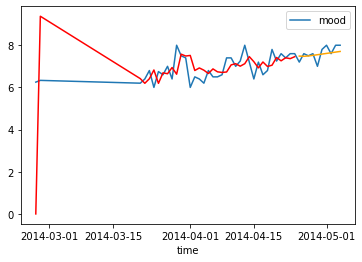

AS14.02
Test MSE: 1.4567901234567904 	for 0.0, 1.0 and 0.0
Test r2: -0.12858660998937355
Test correct: 0.3333333333333333


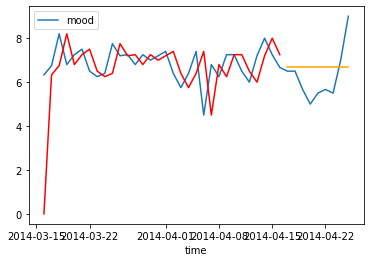

AS14.03
Test MSE: 0.0668982378149755 	for 2.0, 1.0 and 2.0
Test r2: 0.023383389562401602
Test correct: 1.0


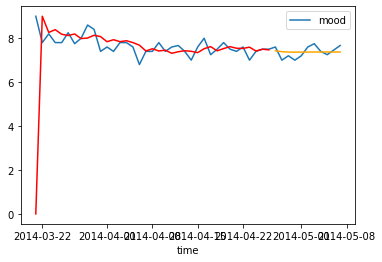

AS14.05
Test MSE: 0.10480448350362023 	for 2.0, 1.0 and 2.0
Test r2: 0.19172775372371875
Test correct: 0.9090909090909091


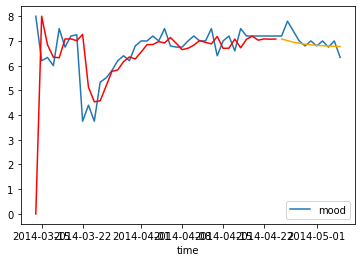

AS14.06
Test MSE: 0.2341773378062422 	for 0.0, 1.0 and 1.0
Test r2: -0.029490603110210012
Test correct: 0.7777777777777778


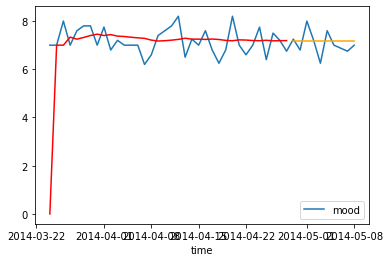

AS14.07
Test MSE: 0.8107397684037003 	for 1.0, 0.0 and 0.0
Test r2: -0.0004706992631249296
Test correct: 0.4


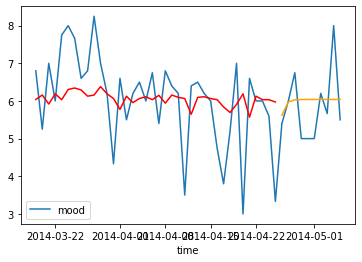

AS14.08
Test MSE: 0.33180831580701564 	for 3.0, 1.0 and 1.0
Test r2: -0.0561040624907827
Test correct: 0.46153846153846156


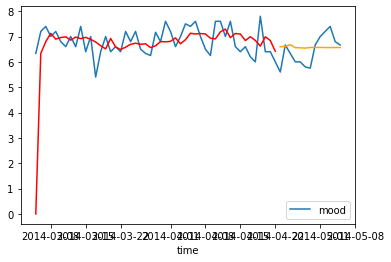

AS14.09
Test MSE: 0.33969189746688055 	for 2.0, 0.0 and 2.0
Test r2: 0.17495440532666096
Test correct: 0.4


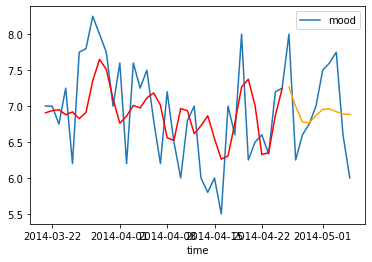

AS14.12
Test MSE: 0.4093244676269785 	for 2.0, 1.0 and 1.0
Test r2: -0.6821553464122403
Test correct: 0.6666666666666666


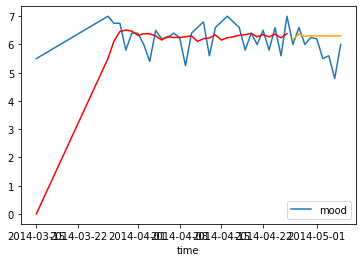

AS14.13
Test MSE: 0.49089938901682806 	for 0.0, 2.0 and 1.0
Test r2: -2.025835203845057
Test correct: 0.45454545454545453


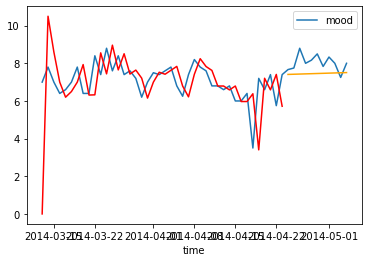

AS14.14
Test MSE: 0.369213919752525 	for 3.0, 1.0 and 2.0
Test r2: 0.060993066216889824
Test correct: 0.5555555555555556


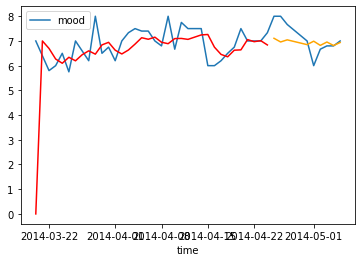

AS14.15
Test MSE: 0.09110527051486868 	for 0.0, 1.0 and 1.0
Test r2: -0.03606557634390106
Test correct: 0.9090909090909091


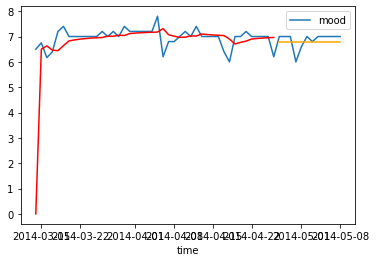

AS14.16
Test MSE: 0.3806473977487501 	for 3.0, 2.0 and 0.0
Test r2: 0.11713962803175759
Test correct: 0.7272727272727273


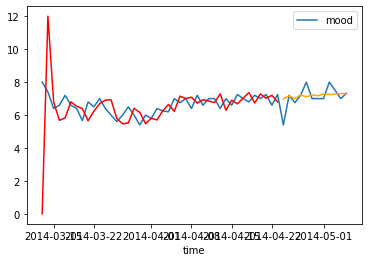

AS14.17
Test MSE: 0.13495072299353525 	for 3.0, 0.0 and 2.0
Test r2: 0.0017771100003041163
Test correct: 0.8333333333333334


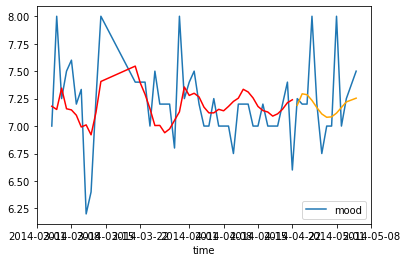

AS14.19
Test MSE: 0.23363820676592714 	for 3.0, 2.0 and 1.0
Test r2: 0.026067849657441466
Test correct: 0.8


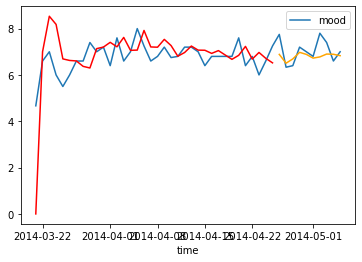

AS14.20
Test MSE: 0.03561093156352042 	for 1.0, 2.0 and 1.0
Test r2: -0.005012179591358912
Test correct: 1.0


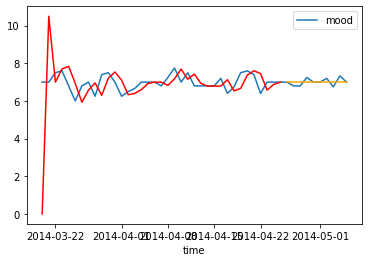

AS14.23
Test MSE: 0.4676031127485436 	for 1.0, 2.0 and 2.0
Test r2: -0.33184687209198005
Test correct: 0.75


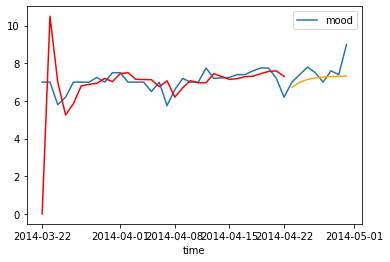

AS14.24
Test MSE: 0.21072647167812414 	for 3.0, 0.0 and 2.0
Test r2: -0.10319509486083733
Test correct: 0.7272727272727273


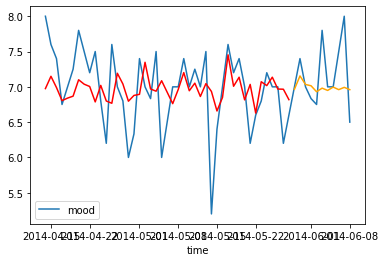

AS14.25
Test MSE: 0.04831594918756732 	for 3.0, 2.0 and 0.0
Test r2: 0.3680109997266119
Test correct: 1.0


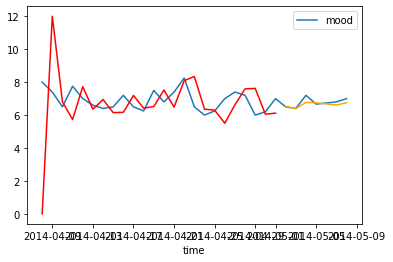

AS14.26
Test MSE: 0.4615265415454252 	for 3.0, 0.0 and 2.0
Test r2: 0.12616690356546212
Test correct: 0.42857142857142855


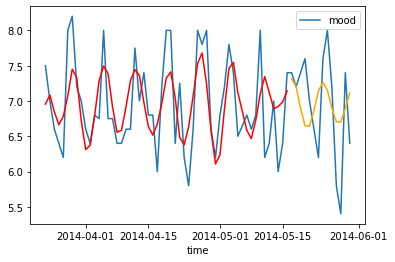

AS14.27
Test MSE: 0.2857846967910592 	for 3.0, 1.0 and 0.0
Test r2: -0.2860311355597669
Test correct: 0.4444444444444444


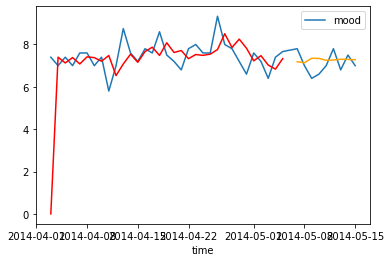

AS14.28
Test MSE: 0.24180555555555572 	for 0.0, 1.0 and 0.0
Test r2: -0.7412176522065255
Test correct: 0.5


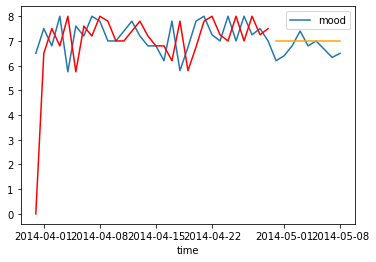

AS14.29
Test MSE: 0.34591692045696926 	for 1.0, 2.0 and 1.0
Test r2: 0.06101640224482163
Test correct: 0.7777777777777778


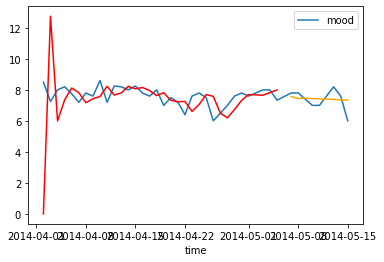

AS14.30
Test MSE: 0.02522132233131768 	for 2.0, 2.0 and 1.0
Test r2: -0.43302967791577873
Test correct: 1.0


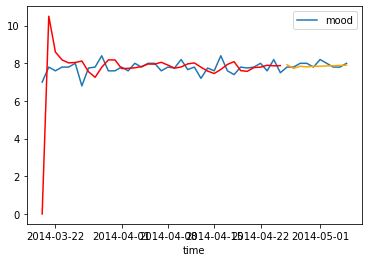

AS14.31
Test MSE: 0.013166787906826067 	for 3.0, 1.0 and 2.0
Test r2: 0.3143865439945538
Test correct: 1.0


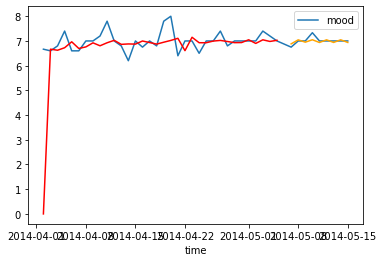

AS14.32
Test MSE: 0.6344256116185855 	for 3.0, 1.0 and 1.0
Test r2: 0.04964851687219041
Test correct: 0.625


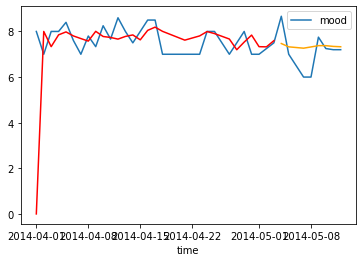

AS14.33
Test MSE: 0.5429868401464617 	for 2.0, 0.0 and 1.0
Test r2: 0.0707823975521239
Test correct: 0.7777777777777778


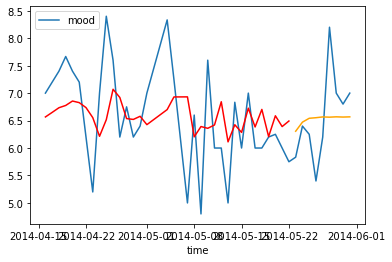

In [25]:
# Plot arima fitted values and forecasting for each person
for person in df.id.unique():
    print(person)
    
    # Get dropna mood set
    mood = getPersonMoodArimaSet(df, person).dropna()

    # Get arima order
    pdq = (df_results.loc[person].p2, df_results.loc[person].d2, df_results.loc[person].q2)
    
    perform_ARIMA(mood, pdq)